## Reading and analysis of NorESM CAM diagnostics files

This notebook provides an interface to read, structure and analyse CAM diagnostics files (see e.g. [here](https://github.com/jgliss/my_notebooks/blob/master/data/from_ada/table_GLBL_ANN_obs.asc) in order to highlight performance of the model runs with respect to each other, relative to observation data (NEED LINK FOR OBS DATA).

MAYBE SOME MORE TEXT HERE IN GENERAL WHAT THIS ALL IS ABOUT

In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import os
import helper_funcs as helpers
import ipywidgets as ipw

### 1. Paths and global settings (GLOB)  

Please change accordingly if you execute this notebook on your local machine.

#### 1.1. Paths (PATHS)

Here you can specify your paths.

In [2]:
#folder with ascii files
data_dir = "./data/michael_ascii_read/"
file_type = "webarchive"

# file containing additional information about variables (long names, can be interactively updated below)
varinfo_csv = "./data/var_info.csv"

# Config file for different groups
vargroups_cfg = "./data/varconfig.ini"

#directy to store results
output_dir = "./output/"

#### 1.2 Global settings (SETUP)

In the following cells you can specify global default settings.

##### 1.2.1 Define group of variables that you are interested in

Default group of variables. Variable groups can be defined in [varconfig.ini](https://github.com/jgliss/my_notebooks/blob/master/data/varconfig.ini). Use ``[group_name]`` to define a new group and add below all variables that should belong to the group in the desired display order (should be self-explanatory when looking at the file, I hope).

In [3]:
var_group = "flagged" #group_name (AS STRING, e.g. "test") from varconfig.ini (use None, if you want to use all)

##### 1.2.2 Add data columns to index

Use the following list to specify table columns that should be added to the multiindex (Ada, here is where you can add "Obs").

In [4]:
add_to_index = [] #NEEDS TO BE A LIST, EVEN FOR ONLY ONE ITEM

##### 1.2.3 Define which parts of index should be unstacked

The following list can be used to specify how the final lists are displayed. The items in the list need to be names of sub-indices in the the Multiindex of the originally loaded file (i.e. "Run", "Years", "Variable", "Description") or data columns that were added to index (previous option). 

All values specified here will be unstacked, i.e. put from the original row into a column index representation (makes table view wider).

In [5]:
unstack_indices = ["Run", "Years"]

##### 1.2.4 Define index levels used for computing statistics (i.e. RMSE relative error)

Specify list of index level names of the original index that are used to compute the mean RMSE (e.g. if you specify

    ["Run", "Years"]
    
than the average RMSE of all runs and years will be computed (for each variable individually).

In [6]:
rmse_stats = ["Run", "Years"]

### 2. Importing and editing supplementary information

Let's begin with reading additional variable information from the file ``varinfo_csv``. Note that this is not strictly required but helps us below to display the results in a more intuitive manner, when analysing the data.

Note that the following method makes sure the CSV file exists, i.e. if it has not been created before, the information is loaded from Michaels Excel table and then saved at ``varinfo_csv``.

In [7]:
var_info_dict = helpers.load_varinfo(varinfo_csv)

The following cell opens an interactive widget that can be used to edit the information available for each variable (stored in file ``varinfo_csv``, see previous cell).

In [8]:
from my_widgets import EditDictCSV

edit_config = EditDictCSV(varinfo_csv)
#show
edit_config()

Now update to the current selection (run everything below if you change the previous cell).

In [9]:
var_info_dict = edit_config.var_dict

### 3. Search and load ASCII files, either using .asc or .webarchive file type (GET_FILES)

The following cell finds all files in folder ``data_dir``.

In [10]:
files = sorted(glob(data_dir + "*.{}".format(file_type)))
for file in files:
    print(file)    

./data/michael_ascii_read/N1850C53CLM45L32_f09_tn11_191017 (yrs 71-100).webarchive
./data/michael_ascii_read/N1850_f09_tn14_230218 (yrs 1-20).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 185-215).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 310-340).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r227_ctrl (yrs 80-110).webarchive
./data/michael_ascii_read/N1850_f19_tn14_r265_ctrl_20180411 (yrs 90-120).webarchive


##### 3.1 Shortcuts for Run IDs (optional may also be changed interactively below)

Define list of shortnames for model runs or define a prefix. If undefined (i.e. empty list and ``None``), the original names are used.

In [11]:
#either
run_ids = list("ABCD") #renames the first 4 runs
#or
run_id_prefix = "Run"


### 4. Importing multiple result files and concatenating them into one Dataframe (LOAD_FILES)

In the following, we load all files into one `Dataframe`. 

To do this, a custom method `read_and_merge_all` was defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). The method basically loops over all files and calls the method ``read_file_custom``, which you can also find in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py). 

In [12]:
merged = helpers.read_and_merge_all(file_list=files, var_info_dict=var_info_dict, replace_runid_prefix=run_id_prefix)
merged

/home/jonasg/github/my_notebooks/helper_funcs.py:151: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.test_case = pd.Series(mapping)


Flag     Model       Obs  \
Run  Years  Variable           Description                                     
Run1 71-100 RESTOM             TOmodel net flux      1.0    -0.489     0.000   
            RESSURF            SRF net flux          1.0    -0.489     0.000   
            RESTOA_CERES-EBAF  TOA  net flux         1.0     1.529     0.992   
            RESTOA_ERBE                              0.0     1.529     0.059   
            SOLIN_CERES-EBAF                         0.0   340.206   340.054   
            SOLIN_CERES                              0.0   340.206   341.479   
            CLDTOT_ISCCP       Total cloud cover     1.0    63.621    66.800   
            CLDTOT_CLOUDSAT                          0.0    63.621    66.824   
            FLDS_ISCCP         LW down SRF           1.0   338.280   343.347   
            FLNS_ISCCP         LW net SRF            1.0    55.819    49.425   
            FLUT_CERES-EBAF    LW up Top             1.0   238.148   239.574   
            FLUT_CERES                               0.0   238.148   238.963   
            FLUT_ERBE                                0.0   238.148   233.946   
            FLUTC_CERES-EBAF   LW up Top Clearsky    1.0   261.783   266.051   
            FLUTC_CERES                              0.0   261.783   266.878   
            FLUTC_ERBE                               0.0   261.783   264.429   
            FLNT_CAM                                 0.0   236.838       NaN   
            FSDS_ISCCP         SW down SRF           1.0   187.801   189.390   
            FSNS_ISCCP         SW net SRF            1.0   163.679   165.893   
            FSNS_LARYEA                              0.0   163.679   154.089   
            FSNTOA_CERES-EBAF                        0.0   239.677   240.566   
            FSNTOA_CERES       SW net TOA            1.0   239.677   244.691   
            FSNTOA_ERBE                              0.0   239.677   234.004   
            FSNTOAC_CERES-EBAF                       0.0   287.999   287.638   
            FSNTOAC_CERES      SW net TOA clearsky   1.0   287.999   294.702   
            FSNTOAC_ERBE                             0.0   287.999   289.329   
            FSNT_CAM                                 0.0   236.348       NaN   
            LHFLX_JRA25        Lat Heat Flux         1.0    87.904    87.935   
            LHFLX_ERA40                              0.0    87.904    82.367   
            LHFLX_WHOI                               0.0    87.904    89.083   
...                                                  ...       ...       ...   
Run4 90-120 PRECT_GPCP         Precipitation         1.0     2.918     2.674   
            PREH2O_NVAP                              0.0    25.733    24.597   
            PREH2O_AIRS                              0.0    25.733    20.425   
            PREH2O_JRA25                             0.0    25.733    20.425   
            PREH2O_ERAI                              0.0    25.733    24.247   
            PREH2O_ERA40       Precipitable water    1.0    25.733    24.948   
            PSL_JRA25          SeaLev pressure       1.0  1011.614  1011.280   
            PSL_ERAI                                 0.0  1011.614  1011.362   
            SHFLX_JRA25        Sens Heat Flux        1.0    22.229    19.372   
            SHFLX_NCEP                               0.0    22.229    15.795   
            SHFLX_LARYEA                             0.0    22.229    13.236   
            STRESS_MAG_ERS                           0.0     0.063     0.064   
            STRESS_MAG_LARYEA                        0.0     0.063     0.071   
            STRESS_MAG_JRA25                         0.0     0.063     0.080   
            SWCF_CERES-EBAF    SW Cloud Forc         1.0   -48.959   -47.071   
            SWCF_CERES                               0.0   -48.959   -48.586   
            SWCF_ERBE                                0.0   -48.959   -54.163   
            AODVIS                                  

### 5. Rearranging and restructuring of the imported data (REARRANGE)

#### 5.1 Computing RMSE relative error (GET_RMSE_REL)

In the following we extract the subset containing the *RSME* information of the flagged variables for all runs in order to compute the relative error for each run based on the average *RMSE* of all runs:

$$\frac{RMSE_{Run}\,-\,\overline{RMSE_{All\,Runs}}}{\overline{RMSE_{All\,Runs}}}$$


In [13]:
merged = helpers.calc_and_add_relerror(merged, colname="RMSE", unstack_indices=rmse_stats)
merged

Flag     Model       Obs  \
Run  Years  Variable           Description                                     
Run1 71-100 RESTOM             TOmodel net flux      1.0    -0.489     0.000   
            RESSURF            SRF net flux          1.0    -0.489     0.000   
            RESTOA_CERES-EBAF  TOA  net flux         1.0     1.529     0.992   
            RESTOA_ERBE                              0.0     1.529     0.059   
            SOLIN_CERES-EBAF                         0.0   340.206   340.054   
            SOLIN_CERES                              0.0   340.206   341.479   
            CLDTOT_ISCCP       Total cloud cover     1.0    63.621    66.800   
            CLDTOT_CLOUDSAT                          0.0    63.621    66.824   
            FLDS_ISCCP         LW down SRF           1.0   338.280   343.347   
            FLNS_ISCCP         LW net SRF            1.0    55.819    49.425   
            FLUT_CERES-EBAF    LW up Top             1.0   238.148   239.574   
            FLUT_CERES                               0.0   238.148   238.963   
            FLUT_ERBE                                0.0   238.148   233.946   
            FLUTC_CERES-EBAF   LW up Top Clearsky    1.0   261.783   266.051   
            FLUTC_CERES                              0.0   261.783   266.878   
            FLUTC_ERBE                               0.0   261.783   264.429   
            FLNT_CAM                                 0.0   236.838       NaN   
            FSDS_ISCCP         SW down SRF           1.0   187.801   189.390   
            FSNS_ISCCP         SW net SRF            1.0   163.679   165.893   
            FSNS_LARYEA                              0.0   163.679   154.089   
            FSNTOA_CERES-EBAF                        0.0   239.677   240.566   
            FSNTOA_CERES       SW net TOA            1.0   239.677   244.691   
            FSNTOA_ERBE                              0.0   239.677   234.004   
            FSNTOAC_CERES-EBAF                       0.0   287.999   287.638   
            FSNTOAC_CERES      SW net TOA clearsky   1.0   287.999   294.702   
            FSNTOAC_ERBE                             0.0   287.999   289.329   
            FSNT_CAM                                 0.0   236.348       NaN   
            LHFLX_JRA25        Lat Heat Flux         1.0    87.904    87.935   
            LHFLX_ERA40                              0.0    87.904    82.367   
            LHFLX_WHOI                               0.0    87.904    89.083   
...                                                  ...       ...       ...   
Run4 90-120 PRECT_GPCP         Precipitation         1.0     2.918     2.674   
            PREH2O_NVAP                              0.0    25.733    24.597   
            PREH2O_AIRS                              0.0    25.733    20.425   
            PREH2O_JRA25                             0.0    25.733    20.425   
            PREH2O_ERAI                              0.0    25.733    24.247   
            PREH2O_ERA40       Precipitable water    1.0    25.733    24.948   
            PSL_JRA25          SeaLev pressure       1.0  1011.614  1011.280   
            PSL_ERAI                                 0.0  1011.614  1011.362   
            SHFLX_JRA25        Sens Heat Flux        1.0    22.229    19.372   
            SHFLX_NCEP                               0.0    22.229    15.795   
            SHFLX_LARYEA                             0.0    22.229    13.236   
            STRESS_MAG_ERS                           0.0     0.063     0.064   
            STRESS_MAG_LARYEA                        0.0     0.063     0.071   
            STRESS_MAG_JRA25                         0.0     0.063     0.080   
            SWCF_CERES-EBAF    SW Cloud Forc         1.0   -48.959   -47.071   
            SWCF_CERES                               0.0   -48.959   -48.586   
            SWCF_ERBE                                0.0   -48.959   -54.163   
            AODVIS                                  

#### 5.2 Interactive manipulation of Dataframe (DF_EDIT)

The following table widget uses the loaded Dataframes and applies all settings that were defined above.  

**NOTE**: the following interactive widget is a BETA version, please let me know if something does not work. It should prepare the dataframe according to your specified options above so that you can run the whole notebook and get your output even if parts of the interactivity do not work yet.

In [14]:
from my_widgets import TableEditor
edit = TableEditor(df=merged, 
                   save_dir=output_dir, #defined above
                   preconfig_file=vargroups_cfg, #defined above
                   default_group=var_group, #defined above
                   new_run_names=run_ids, #defined above
                   add_to_index_vars=add_to_index, #defined above
                   unstack_indices=unstack_indices) #defined above
                   
edit()

Now access the current selection and continue.

In [24]:
selection = edit.df_edit
selection

Run                                     A       B       C                  \
Years                              71-100    1-20 185-215 310-340  80-110   
Variable        Description                                                 
RESTOM          TOmodel net flux      NaN     NaN     NaN     NaN     NaN   
CLDTOT_ISCCP    Total cloud cover  11.323  11.881  12.992  13.078  12.869   
FLDS_ISCCP      LW down SRF        14.450  15.351  16.891  17.664  16.720   
SWCF_CERES-EBAF SW Cloud Forc      10.324   8.854  10.447  10.563  10.393   
U_200_JRA25     Zonal Wind JRA25    2.444   2.852   4.334   4.348   4.335   

Run                                     D  
Years                              90-120  
Variable        Description                
RESTOM          TOmodel net flux      NaN  
CLDTOT_ISCCP    Total cloud cover  12.485  
FLDS_ISCCP      LW down SRF        15.278  
SWCF_CERES-EBAF SW Cloud Forc       9.973  
U_200_JRA25     Zonal Wind JRA25    3.342

#### 5.3 Extracting the Bias of each model run relative to the observations (GET_BIAS)

Retrieving a table that illustrates the Bias of each run for each flagged variable is straight forward. We just extract the `Bias` column from our flagged frame:

In [16]:
bias = selection["Bias"]
bias

Run                                        A      B       C                 \
Years                                 71-100   1-20 185-215 310-340 80-110   
Variable          Description                                                
RESTOM            TOmodel net flux    -0.489  0.987   0.468   0.327  0.647   
RESSURF           SRF net flux        -0.489  0.974   0.474   0.337  0.643   
RESTOA_CERES-EBAF TOA  net flux        0.537  2.083   1.561   1.420  1.741   
CLDTOT_ISCCP      Total cloud cover   -3.179  1.786   1.744   1.435  2.157   
FLDS_ISCCP        LW down SRF         -5.066 -1.799  10.514  11.499  5.162   
FLNS_ISCCP        LW net SRF           6.394  9.699   6.824   6.847  7.167   
FLUT_CERES-EBAF   LW up Top           -1.426  1.704   2.398   2.928  0.660   
FLUTC_CERES-EBAF  LW up Top Clearsky  -4.268 -0.986   1.039   1.426 -0.786   
FSDS_ISCCP        SW down SRF         -1.589  3.200   1.068   1.228  1.216   
FSNS_ISCCP        SW net SRF          -2.214  2.630   1.070   1.365 -0.017   
FSNTOA_CERES      SW net TOA          -5.015 -0.338  -0.167   0.223 -1.724   
FSNTOAC_CERES     SW net TOA clearsky -6.703 -5.051  -4.373  -4.183 -5.747   
LHFLX_JRA25       Lat Heat Flux       -0.031 -2.503  -0.009   0.434 -1.695   
LWCF_CERES-EBAF   LW Cloud Forc       -2.841 -2.689  -1.357  -1.501 -1.446   
PRECT_GPCP        Precipitation        0.329  0.246   0.336   0.352  0.276   
PREH2O_ERA40      Precipitable water  -0.975 -0.511   3.143   3.437  1.922   
PSL_JRA25         SeaLev pressure      0.002  0.004   0.491   0.513  0.448   
SHFLX_JRA25       Sens Heat Flux       1.074  3.621   2.942   2.907  3.028   
SWCF_CERES-EBAF   SW Cloud Forc       -1.252  1.774   1.266   1.466  1.083   
SST_HADISST_PI    SST preindustrial   -0.108  0.782   2.217   2.385  1.756   
TREFHT_JRA25      2m Temp             -1.098 -0.263   1.434   1.615  0.431   
TS_NCEP           2m Temp             -0.346  0.876   2.579   2.767  1.564   
TS_LAND_NCEP      2m Temp land        -0.524  1.237   3.765   3.945  2.181   
U_200_JRA25       Zonal Wind JRA25     1.006  1.825   3.209   3.218  3.340   
Z3_500_JRA25      Geop Height  JRA25  -0.254 -0.090   0.278   0.317  0.113   

Run                                        D  
Years                                 90-120  
Variable          Description                 
RESTOM            TOmodel net flux    -0.075  
RESSURF           SRF net flux        -0.075  
RESTOA_CERES-EBAF TOA  net flux        1.021  
CLDTOT_ISCCP      Total cloud cover    3.947  
FLDS_ISCCP        LW down SRF          4.507  
FLNS_ISCCP        LW net SRF           6.925  
FLUT_CERES-EBAF   LW up Top           -0.832  
FLUTC_CERES-EBAF  LW up Top Clearsky  -1.182  
FSDS_ISCCP        SW down SRF         -1.721  
FSNS_ISCCP        SW net SRF          -2.145  
FSNTOA_CERES      SW net TOA          -3.937  
FSNTOAC_CERES     SW net TOA clearsky -4.988  
LHFLX_JRA25       Lat Heat Flux       -2.692  
LWCF_CERES-EBAF   LW Cloud Forc       -0.349  
PRECT_GPCP        Precipitation        0.244  
PREH2O_ERA40      Precipitable water   0.785  
PSL_JRA25         SeaLev pressure      0.335  
SHFLX_JRA25       Sens Heat Flux       2.857  
SWCF_CERES-EBAF   SW Cloud Forc       -1.888  
SST_HADISST_PI    SST preindustrial    1.358  
TREFHT_JRA25      2m Temp              0.344  
TS_NCEP           2m Temp              1.518  
TS_LAND_NCEP      2m Temp land         2.153  
U_200_JRA25       Zonal Wind JRA25     2.304  
Z3_500_JRA25      Geop Height  JRA25  -0.014

#### 5.4 Extracting the RMSE error of each model run relative to the observations (GET_RMSE_ERR)

In section 5.1 we computed and added the relative RMSE error as a new column to the original table. These data can now be accessed as simply as the ``Bias`` table:

In [17]:
rmse_err_rel = selection["RMSE_ERR"]
rmse_err_rel

Run                                           A         B         C            \
Years                                    71-100      1-20   185-215   310-340   
Variable          Description                                                   
RESTOM            TOmodel net flux          NaN       NaN       NaN       NaN   
RESSURF           SRF net flux              NaN       NaN       NaN       NaN   
RESTOA_CERES-EBAF TOA  net flux       -0.014764 -0.068695  0.004067 -0.004179   
CLDTOT_ISCCP      Total cloud cover   -0.089645 -0.044782  0.044541  0.051455   
FLDS_ISCCP        LW down SRF         -0.100193 -0.044087  0.051809  0.099944   
FLNS_ISCCP        LW net SRF          -0.142110  0.071951  0.010658  0.016106   
FLUT_CERES-EBAF   LW up Top           -0.015463 -0.113989  0.032363  0.072434   
FLUTC_CERES-EBAF  LW up Top Clearsky   0.182079 -0.065215 -0.087909 -0.073040   
FSDS_ISCCP        SW down SRF         -0.126774 -0.015239  0.038669  0.049568   
FSNS_ISCCP        SW net SRF          -0.039834 -0.045801  0.026338  0.036913   
FSNTOA_CERES      SW net TOA           0.020650 -0.104744  0.003151  0.005556   
FSNTOAC_CERES     SW net TOA clearsky  0.068048  0.008680 -0.075512 -0.090962   
LHFLX_JRA25       Lat Heat Flux        0.113433 -0.054982 -0.031062 -0.020107   
LWCF_CERES-EBAF   LW Cloud Forc        0.044275 -0.035963 -0.005937  0.014419   
PRECT_GPCP        Precipitation        0.125424 -0.137046  0.010169  0.035351   
PREH2O_ERA40      Precipitable water  -0.298901 -0.373027  0.356155  0.446609   
PSL_JRA25         SeaLev pressure     -0.219250 -0.114408  0.068918  0.135689   
SHFLX_JRA25       Sens Heat Flux       0.028224  0.042650 -0.033849 -0.026243   
SWCF_CERES-EBAF   SW Cloud Forc        0.022955 -0.122700  0.035142  0.046636   
SST_HADISST_PI    SST preindustrial   -0.433336 -0.345581  0.315259  0.394453   
TREFHT_JRA25      2m Temp             -0.025184 -0.177131  0.068257  0.108664   
TS_NCEP           2m Temp             -0.292989 -0.175746  0.201563  0.253790   
TS_LAND_NCEP      2m Temp land        -0.316903 -0.226794  0.251152  0.290899   
U_200_JRA25       Zonal Wind JRA25    -0.322835 -0.209790  0.200831  0.204710   
Z3_500_JRA25      Geop Height  JRA25  -0.076923 -0.367033  0.289011  0.394505   

Run                                                     D  
Years                                    80-110    90-120  
Variable          Description                              
RESTOM            TOmodel net flux          NaN       NaN  
RESSURF           SRF net flux              NaN       NaN  
RESTOA_CERES-EBAF TOA  net flux       -0.011421  0.094991  
CLDTOT_ISCCP      Total cloud cover    0.034652  0.003779  
FLDS_ISCCP        LW down SRF          0.041161 -0.048633  
FLNS_ISCCP        LW net SRF           0.040623  0.002772  
FLUT_CERES-EBAF   LW up Top            0.077030 -0.052375  
FLUTC_CERES-EBAF  LW up Top Clearsky   0.109300 -0.065215  
FSDS_ISCCP        SW down SRF          0.047349  0.006428  
FSNS_ISCCP        SW net SRF           0.035251 -0.012867  
FSNTOA_CERES      SW net TOA           0.021231  0.054155  
FSNTOAC_CERES     SW net TOA clearsky  0.070825  0.018921  
LHFLX_JRA25       Lat Heat Flux        0.010426 -0.017708  
LWCF_CERES-EBAF   LW Cloud Forc        0.020865 -0.037659  
PRECT_GPCP        Precipitation        0.021792 -0.055690  
PREH2O_ERA40      Precipitable water   0.094264 -0.225101  
PSL_JRA25         SeaLev pressure      0.136275 -0.007224  
SHFLX_JRA25       Sens Heat Flux       0.009865 -0.020647  
SWCF_CERES-EBAF   SW Cloud Forc        0.029792 -0.011824  
SST_HADISST_PI    SST preindustrial    0.142424 -0.073219  
TREFHT_JRA25      2m Temp              0.121712 -0.096317  
TS_NCEP           2m Temp              0.067267 -0.053884  
TS_LAND_NCEP      2m Temp land         0.027979 -0.026333  
U_200_JRA25       Zonal Wind JRA25     0.201108 -0.074024  
Z3_500_JRA25      Geop Height  JRA25   0.104396 -0.343956

### 6. Conditional formatting of tables (Dataframes) (VISUALISE)

This section illustrates, how we can perform conditional formatting of the color tables. This can either be performed in the browser (rendering of HTML representation of Dataframe) or by plotting them as a heatmap using the [seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

#### 6.1 HTML preview using pandas styling options (DISP_HTML_NOSAVE)

Use [pandas styling options](https://pandas.pydata.org/pandas-docs/stable/style.html) to render color formatted table preview. Gets us a nice preview, problem is, however, that it cannot be exported as png, pdf, etc. out of the box.

In the following, we use a custom display method `my_table_display` (that is defined in [helper_funcs.py](https://github.com/jgliss/my_py3_scripts/blob/master/notebooks/helper_funcs.py)) in order to perform colour formatting considering all rows and columns at the same time and furthermore, using a diverging colour map that is dynamically shifted such that value 0 corresponds to the colour white (method `shifted_color_map`) also if `-vmin != vmax` (like usually).

In [18]:
from helper_funcs import my_table_display
my_table_display(bias)

In [19]:
my_table_display(rmse_err_rel)

/home/jonasg/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


#### 6.2 Rendered preview using seaborn (DISP_AS_PLOT)

Render table preview in browser directly using [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). Gets us a nice preview and the possibility to edit display and save figure as png, etc in a very flexible manner.

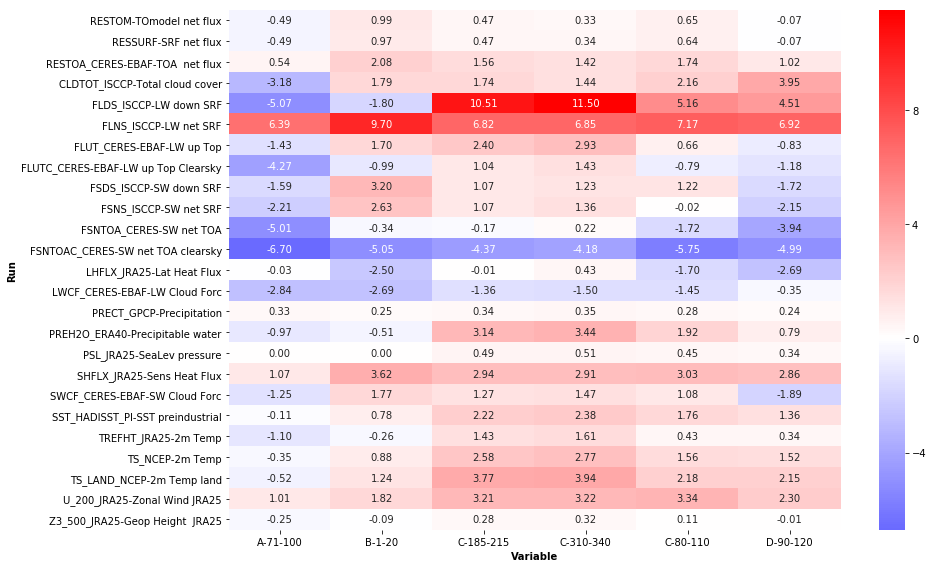

In [20]:
from helper_funcs import df_to_heatmap

ax = df_to_heatmap(bias, figsize=(14,8))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "bias_table.png"))

Now for the typical RMSE error

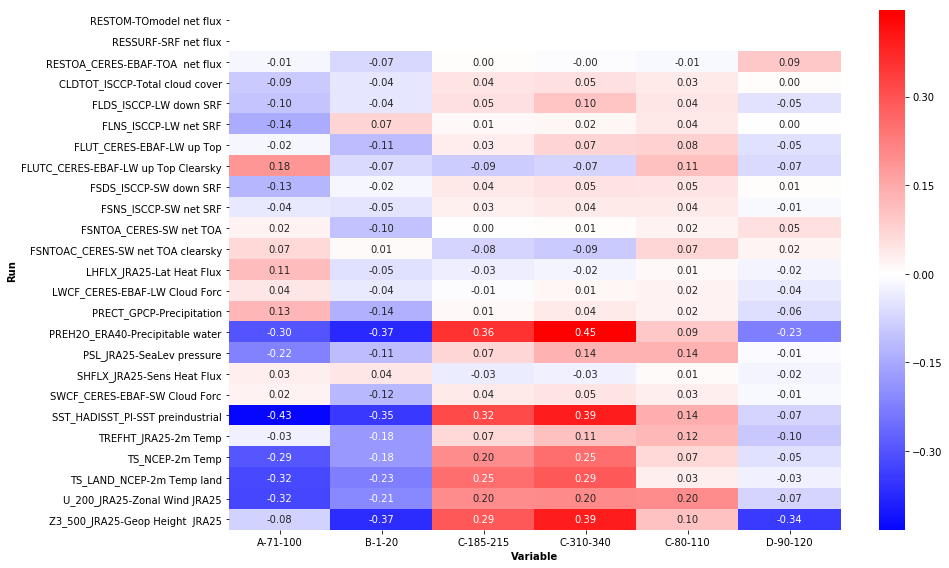

In [21]:
ax = df_to_heatmap(rmse_err_rel, figsize=(14,8))
ax.set_xlabel("Variable", weight="bold")
ax.set_ylabel("Run", weight="bold")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(output_dir, "rmse_err_table.png"))

### 7. Concatenate and save results (Bias and typical RMSE) as table (EXPORT)

In the following, the two result tables ``bias_table`` and ``typical_rmse`` are merged into one result table and then saved both as excel table and as csv file.

In [22]:
result = pd.concat([bias, rmse_err_rel],axis=1, keys=["Bias", "RMSE relative Error"])
result

Bias                                \
Run                                        A      B       C                  
Years                                 71-100   1-20 185-215 310-340 80-110   
Variable          Description                                                
RESTOM            TOmodel net flux    -0.489  0.987   0.468   0.327  0.647   
RESSURF           SRF net flux        -0.489  0.974   0.474   0.337  0.643   
RESTOA_CERES-EBAF TOA  net flux        0.537  2.083   1.561   1.420  1.741   
CLDTOT_ISCCP      Total cloud cover   -3.179  1.786   1.744   1.435  2.157   
FLDS_ISCCP        LW down SRF         -5.066 -1.799  10.514  11.499  5.162   
FLNS_ISCCP        LW net SRF           6.394  9.699   6.824   6.847  7.167   
FLUT_CERES-EBAF   LW up Top           -1.426  1.704   2.398   2.928  0.660   
FLUTC_CERES-EBAF  LW up Top Clearsky  -4.268 -0.986   1.039   1.426 -0.786   
FSDS_ISCCP        SW down SRF         -1.589  3.200   1.068   1.228  1.216   
FSNS_ISCCP        SW net SRF          -2.214  2.630   1.070   1.365 -0.017   
FSNTOA_CERES      SW net TOA          -5.015 -0.338  -0.167   0.223 -1.724   
FSNTOAC_CERES     SW net TOA clearsky -6.703 -5.051  -4.373  -4.183 -5.747   
LHFLX_JRA25       Lat Heat Flux       -0.031 -2.503  -0.009   0.434 -1.695   
LWCF_CERES-EBAF   LW Cloud Forc       -2.841 -2.689  -1.357  -1.501 -1.446   
PRECT_GPCP        Precipitation        0.329  0.246   0.336   0.352  0.276   
PREH2O_ERA40      Precipitable water  -0.975 -0.511   3.143   3.437  1.922   
PSL_JRA25         SeaLev pressure      0.002  0.004   0.491   0.513  0.448   
SHFLX_JRA25       Sens Heat Flux       1.074  3.621   2.942   2.907  3.028   
SWCF_CERES-EBAF   SW Cloud Forc       -1.252  1.774   1.266   1.466  1.083   
SST_HADISST_PI    SST preindustrial   -0.108  0.782   2.217   2.385  1.756   
TREFHT_JRA25      2m Temp             -1.098 -0.263   1.434   1.615  0.431   
TS_NCEP           2m Temp             -0.346  0.876   2.579   2.767  1.564   
TS_LAND_NCEP      2m Temp land        -0.524  1.237   3.765   3.945  2.181   
U_200_JRA25       Zonal Wind JRA25     1.006  1.825   3.209   3.218  3.340   
Z3_500_JRA25      Geop Height  JRA25  -0.254 -0.090   0.278   0.317  0.113   

                                             RMSE relative Error            \
Run                                        D                   A         B   
Years                                 90-120              71-100      1-20   
Variable          Description                                                
RESTOM            TOmodel net flux    -0.075                 NaN       NaN   
RESSURF           SRF net flux        -0.075                 NaN       NaN   
RESTOA_CERES-EBAF TOA  net flux        1.021           -0.014764 -0.068695   
CLDTOT_ISCCP      Total cloud cover    3.947           -0.089645 -0.044782   
FLDS_ISCCP        LW down SRF          4.507           -0.100193 -0.044087   
FLNS_ISCCP        LW net SRF           6.925           -0.142110  0.071951   
FLUT_CERES-EBAF   LW up Top           -0.832           -0.015463 -0.113989   
FLUTC_CERES-EBAF  LW up Top Clearsky  -1.182            0.182079 -0.065215   
FSDS_ISCCP        SW down SRF         -1.721           -0.126774 -0.015239   
FSNS_ISCCP        SW net SRF          -2.145           -0.039834 -0.045801   
FSNTOA_CERES      SW net TOA          -3.937            0.020650 -0.104744   
FSNTOAC_CERES     SW net TOA clearsky -4.988            0.068048  0.008680   
LHFLX_JRA25       Lat Heat Flux       -2.692            0.113433 -0.054982   
LWCF_CERES-EBAF   LW Cloud Forc       -0.349            0.044275 -0.035963   
PRECT_GPCP        Precipitation        0.244            0.125424 -0.137046   
PREH2O_ERA40      Precipitable water   0.785           -0.298901 -0.373027   
PSL_JRA25         SeaLev pressure      0.335           -0.219250 -0.114408   
SHFLX_JRA25       Sens Heat Flux       2.857            0.028224  0.042650   
SWCF_CERES-EBAF   SW Cloud Forc       -1.888            0.022

Now save the table as excel file.

In [23]:
writer = pd.ExcelWriter('{}/result.xlsx'.format(output_dir))
result.to_excel(writer)
writer.save()
writer.close()